# Modelado de los datos Fotovoltáico de OBREMO

In [12]:
# Librerías necesarias
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

## 1) Carga de datos

In [13]:
data = pd.read_csv('generation_data.csv')
data.head()

,DATE_TIME,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,0.0,0.0,0.000000,6.837223e+06,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,4136001,0.0,0.0,2222.724459,6.449816e+08,27.004764,25.060789,0.0
2,2020-05-15 00:15:00,4135001,0.0,0.0,0.000000,6.837223e+06,25.084589,22.761668,0.0
3,2020-05-15 00:15:00,4136001,0.0,0.0,1290.954545,6.449816e+08,26.880811,24.421869,0.0
4,2020-05-15 00:30:00,4135001,0.0,0.0,0.000000,6.837223e+06,24.935753,22.592306,0.0


In [26]:
data.dtypes

DATE_TIME               object
PLANT_ID                 int64
DC_POWER               float64
AC_POWER               float64
DAILY_YIELD            float64
TOTAL_YIELD            float64
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
dtype: object

## 2) EDA

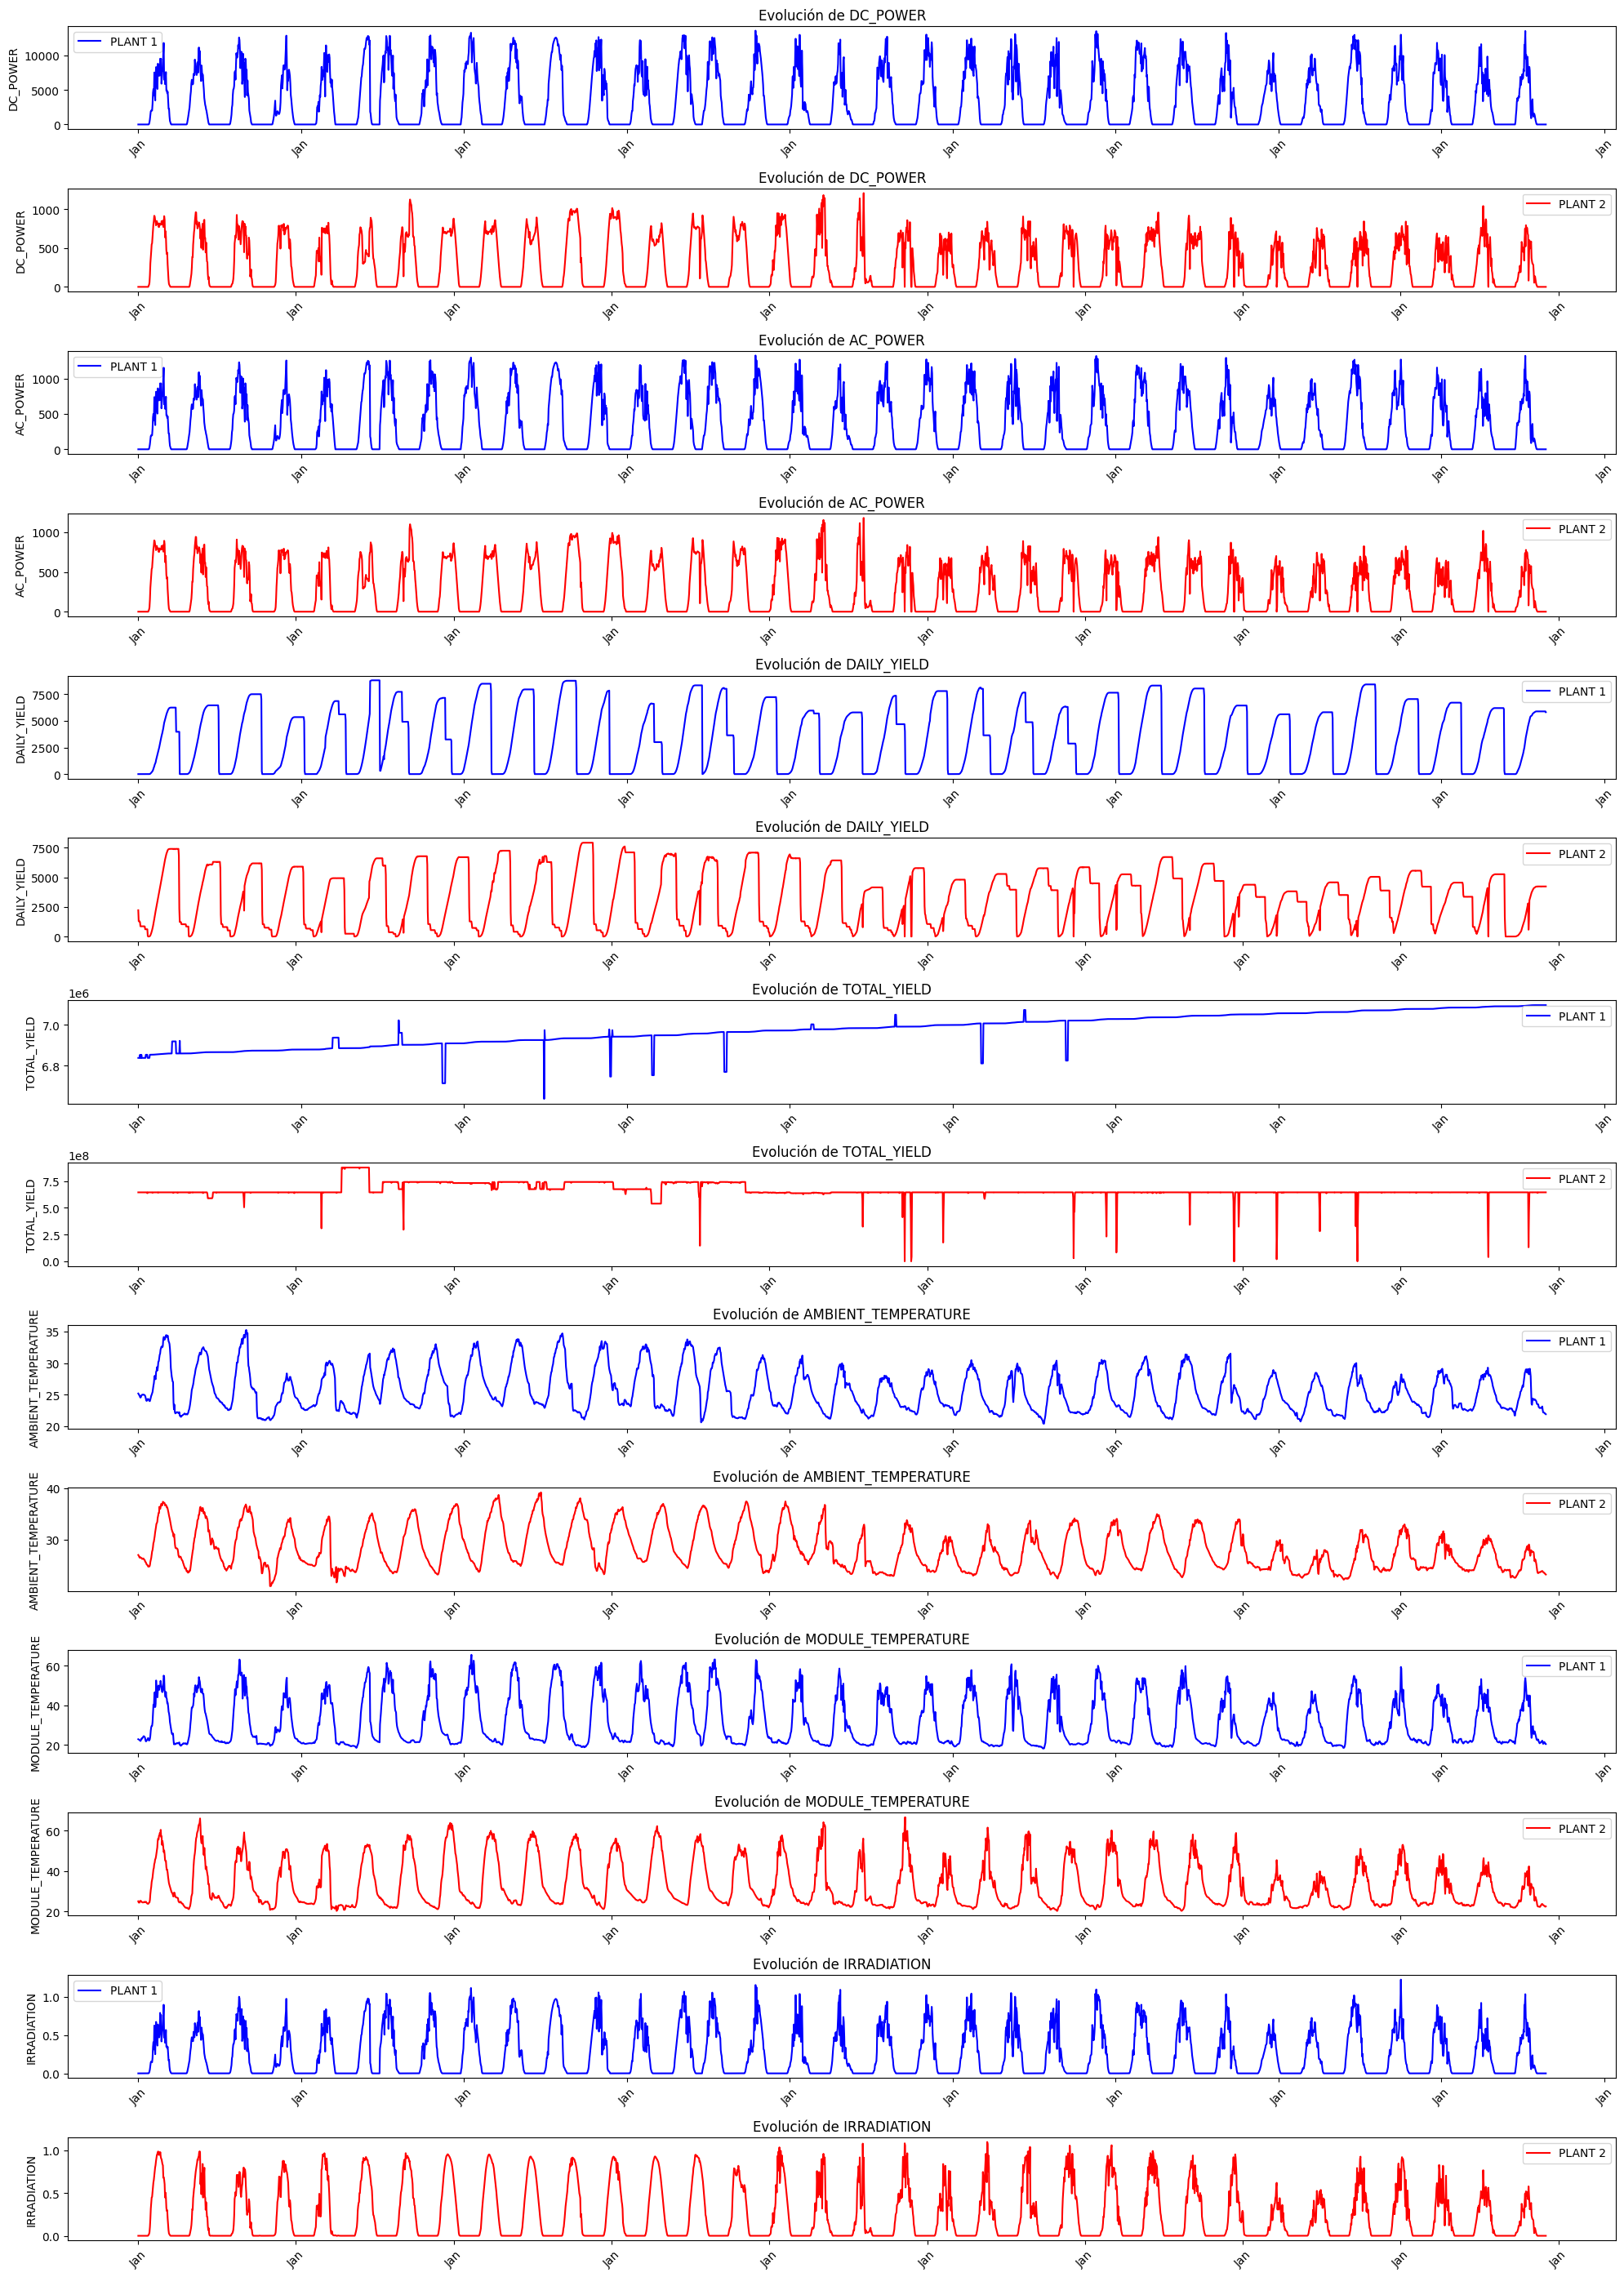

In [30]:
# Evolución de las variables a lo largo del tiempo
df_plot = data.loc[:, "DC_POWER":]
variables = df_plot.columns

fig, axes = plt.subplots(14, 1, figsize=(20, 2 * 14))
axes = axes.flatten()  

df_plot['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])

data_plant_1 = data[data['PLANT_ID'] == 4135001]
data_plant_2 = data[data['PLANT_ID'] == 4136001]

for i, var in enumerate(variables):
    e=i*2
    axes[e].plot(data_plant_1['DATE_TIME'], data_plant_1[var], label='PLANT 1', color='blue')
    axes[e].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[e].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  
    axes[e].tick_params(axis='x', rotation=45)
    axes[e].set_ylabel(var)
    axes[e].set_title(f"Evolución de {var}")
    axes[e].legend()
    
    axes[e+1].plot(data_plant_2['DATE_TIME'], data_plant_2[var], label='PLANT 2', color='red')
    axes[e+1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[e+1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  
    axes[e+1].tick_params(axis='x', rotation=45)
    axes[e+1].set_ylabel(var)
    axes[e+1].set_title(f"Evolución de {var}")
    axes[e+1].legend()


for j in range(e + 2, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

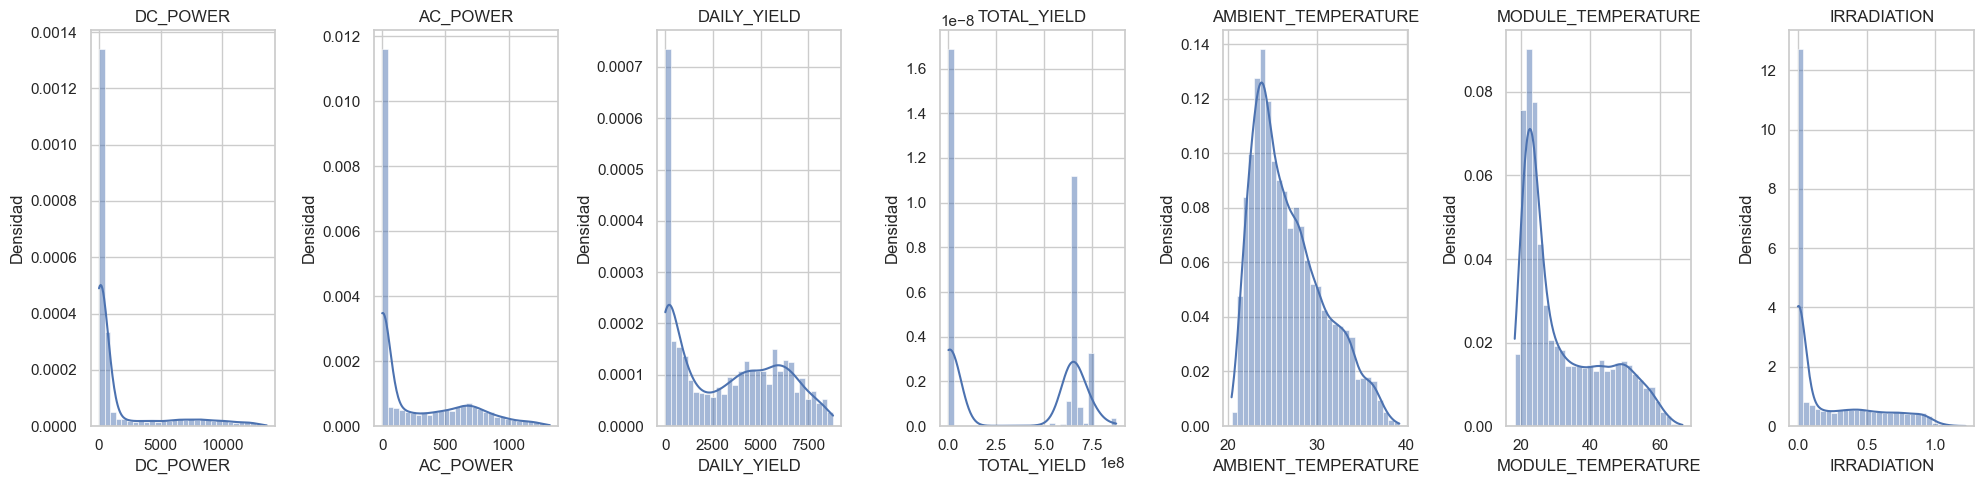

In [31]:
# Histograma de las variables

sns.set(style="whitegrid")
df_plot = data.loc[:,"DC_POWER":]
num_cols = len(df_plot.columns)

fig, axes = plt.subplots(1, 7, figsize=(20, 5))
axes = axes.flatten() 
heights = []

for i, col in enumerate(df_plot.columns):
    histogram = sns.histplot(df_plot[col], ax=axes[i], kde=True, stat="density", bins=30)
    heights.append(max([patch.get_height() for patch in histogram.patches]))
    axes[i].set_title(f'{col}')
    #axes[i].set_xlabel(col)
    axes[i].set_ylabel('Densidad')
    

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

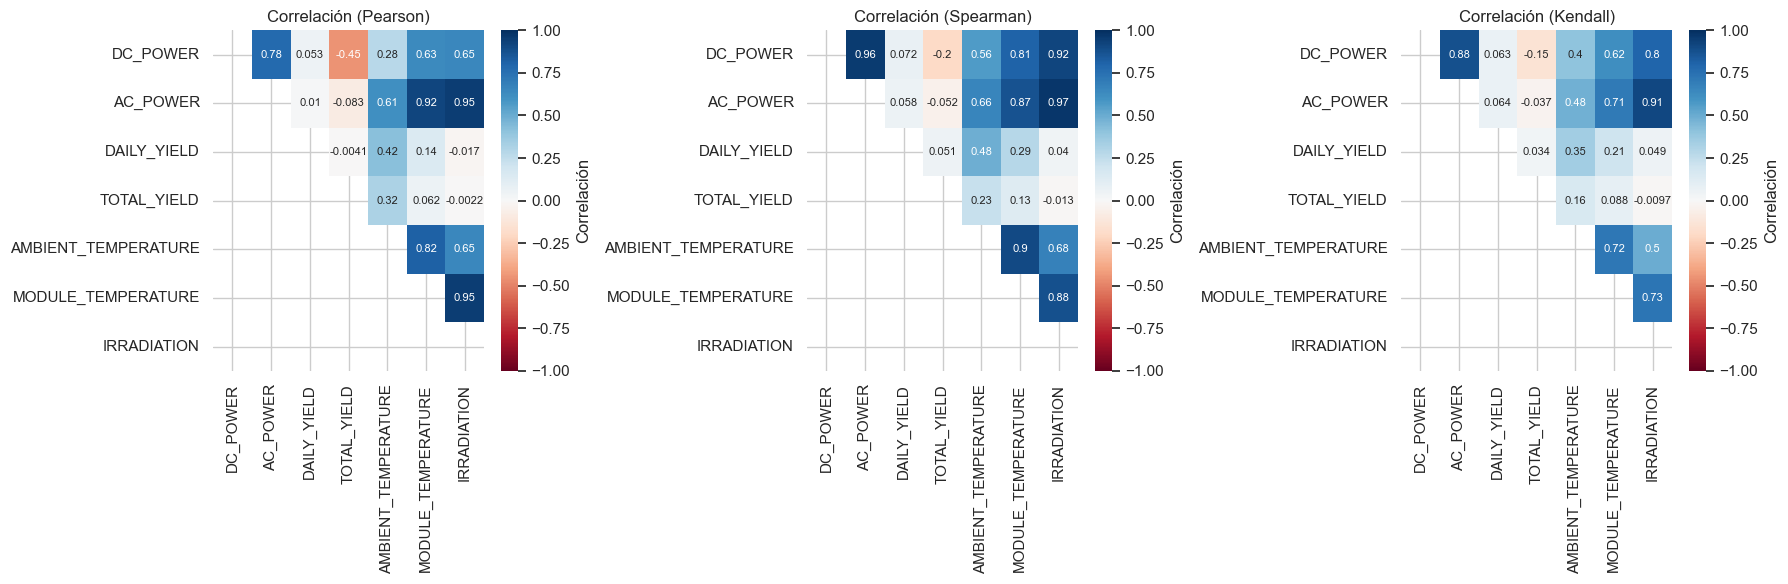

In [32]:
# Mapas de correlaciones
df_mat = data.loc[:, 'DC_POWER':]
pearson = pd.DataFrame(index=df_mat.columns, columns=df_mat.columns)
spearman = pd.DataFrame(index=df_mat.columns, columns=df_mat.columns)
kendall = pd.DataFrame(index=df_mat.columns, columns=df_mat.columns)

# Calcular correlaciones iterando sobre cada par de variables
for i in range(len(df_mat.columns)):
    for j in range(i, len(df_mat.columns)):
        if i == j:
            pass
        else:
            df_aux = df_mat.iloc[:, [i, j]].dropna()
            if df_aux.iloc[:, 0].nunique() <= 1 or df_aux.iloc[:, 1].nunique() <= 1:
                pass
            else:
                nulos = df_aux.isnull().sum().sum()
                pearson.iloc[i, j] = df_aux.iloc[:, 0].corr(df_aux.iloc[:, 1], method='pearson')
                spearman.iloc[i, j] = df_aux.iloc[:, 0].corr(df_aux.iloc[:, 1], method='spearman')
                kendall.iloc[i, j] = df_aux.iloc[:, 0].corr(df_aux.iloc[:, 1], method='kendall')

# Crear los plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(pearson.astype(float), annot=True, cmap='RdBu', vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Correlación'},
            annot_kws={'size': 8})  
axes[0].set_title('Correlación (Pearson)')

sns.heatmap(spearman.astype(float), annot=True, cmap='RdBu', vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Correlación'},
            annot_kws={'size': 8}) 
axes[1].set_title('Correlación (Spearman)')

sns.heatmap(kendall.astype(float), annot=True, cmap='RdBu', vmin=-1, vmax=1, ax=axes[2], cbar_kws={'label': 'Correlación'},
            annot_kws={'size': 8}) 
axes[2].set_title('Correlación (Kendall)')

plt.tight_layout()

plt.show()

## 3) Métodos Soft-learning

In [36]:
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [37]:
print(data.columns)
df = data.loc[:,['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'AC_POWER']]

# Estadarozación del conjunto de datos
scaler = StandardScaler()
data_estandarizada = scaler.fit_transform(df)

predictors = df.loc[:,['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
objective = df['AC_POWER']

Index(['DATE_TIME', 'PLANT_ID', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD',
       'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION'],
      dtype='object')


In [38]:
# Separación de datos para la modelización
X, X_val, y, y_val = train_test_split(predictors, objective, test_size=0.2, random_state=42)

### 3.1) AdaBoostRegressor

Resultados de validación cruzada:
{'R² promedio (CV)': 0.912420816338684, 'MSE promedio (CV)': 10777.01251068134, 'RMSE promedio (CV)': 103.81239093037661, 'MAE promedio (CV)': 51.267012025964185}


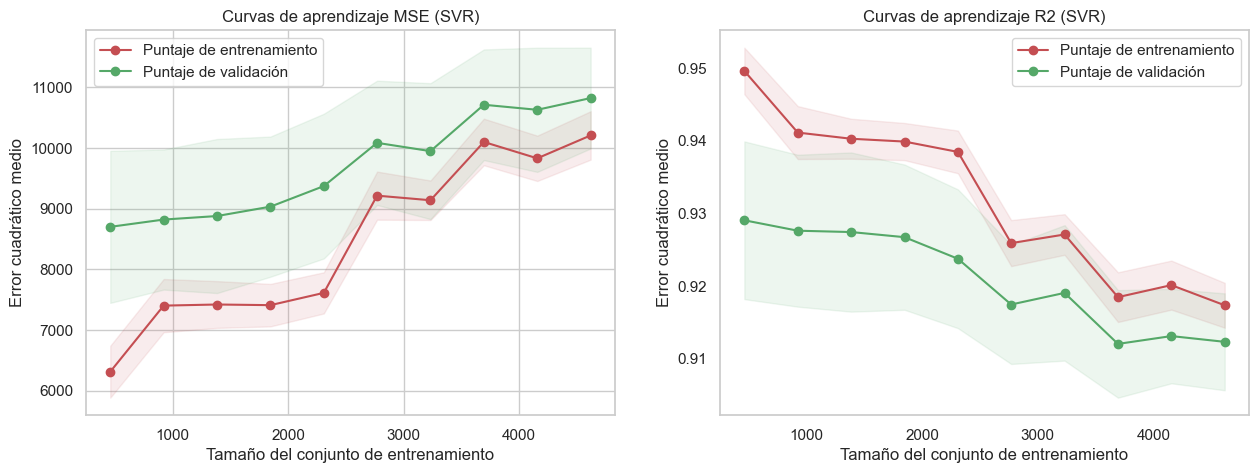

Resultados de validación global:
{'R²': 0.9230912816448494, 'MSE': 9845.484428974542, 'RMSE': 99.2244144803815, 'MAE': 50.11530044945998}


In [39]:
# Diferentes implementaciones de AdaBoostRegressor
# Validación cruzada AdaBoostRegressor
abr = AdaBoostRegressor(learning_rate=0.05, n_estimators=200)

cv = KFold(n_splits=10, shuffle=True, random_state=42)

r2_cv = cross_val_score(abr, X, y, cv=cv, scoring='r2')
mse_cv = cross_val_score(abr, X, y, cv=cv, scoring='neg_mean_squared_error')
mae_cv = cross_val_score(abr, X, y, cv=cv, scoring='neg_mean_absolute_error')

mse_cv = -mse_cv
mae_cv = -mae_cv

r2_mean = np.mean(r2_cv)
mse_mean = np.mean(mse_cv)
rmse_mean = np.sqrt(mse_mean)
mae_mean = np.mean(mae_cv)

resultados_cv = {
    'R² promedio (CV)': float(r2_mean),
    'MSE promedio (CV)': float(mse_mean),
    'RMSE promedio (CV)': float(rmse_mean),
    'MAE promedio (CV)': float(mae_mean)
}

print("Resultados de validación cruzada:")
print(resultados_cv)

# Para mostrar las curvas de aprendizaje
abr = AdaBoostRegressor(learning_rate=0.05, n_estimators=200)

train_sizes_mse, train_scores_mse, test_scores_mse = learning_curve(abr, X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))
train_sizes_r2, train_scores_r2, test_scores_r2 = learning_curve(abr, X, y, cv=cv, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean_mse = -np.mean(train_scores_mse, axis=1)
train_scores_std_mse = np.std(train_scores_mse, axis=1)
test_scores_mean_mse = -np.mean(test_scores_mse, axis=1)
test_scores_std_mse = np.std(test_scores_mse, axis=1)
train_scores_mean_r2 = np.mean(train_scores_r2, axis=1)
train_scores_std_r2 = np.std(train_scores_r2, axis=1)
test_scores_mean_r2 = np.mean(test_scores_r2, axis=1)
test_scores_std_r2 = np.std(test_scores_r2, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].fill_between(train_sizes_mse, train_scores_mean_mse - train_scores_std_mse, train_scores_mean_mse + train_scores_std_mse, alpha=0.1, color="r")
axs[0].fill_between(train_sizes_mse, test_scores_mean_mse - test_scores_std_mse, test_scores_mean_mse + test_scores_std_mse, alpha=0.1, color="g")
axs[0].plot(train_sizes_mse, train_scores_mean_mse, 'o-', color="r", label="Puntaje de entrenamiento")
axs[0].plot(train_sizes_mse, test_scores_mean_mse, 'o-', color="g", label="Puntaje de validación")
axs[0].set_xlabel("Tamaño del conjunto de entrenamiento")
axs[0].set_ylabel("Error cuadrático medio")
axs[0].set_title("Curvas de aprendizaje MSE (SVR)")
axs[0].legend(loc="best")

axs[1].fill_between(train_sizes_r2, train_scores_mean_r2 - train_scores_std_r2, train_scores_mean_r2 + train_scores_std_r2, alpha=0.1, color="r")
axs[1].fill_between(train_sizes_r2, test_scores_mean_r2 - test_scores_std_r2, test_scores_mean_r2 + test_scores_std_r2, alpha=0.1, color="g")
axs[1].plot(train_sizes_r2, train_scores_mean_r2, 'o-', color="r", label="Puntaje de entrenamiento")
axs[1].plot(train_sizes_r2, test_scores_mean_r2, 'o-', color="g", label="Puntaje de validación")
axs[1].set_xlabel("Tamaño del conjunto de entrenamiento")
axs[1].set_ylabel("Error cuadrático medio")
axs[1].set_title("Curvas de aprendizaje R2 (SVR)")
axs[1].legend(loc="best")
plt.grid()
plt.show()

# Para validación sobre datos nuevos
abr = AdaBoostRegressor(learning_rate=0.05, n_estimators=200)
abr.fit(X, y)
y_pred = abr.predict(X_val) 

r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred) 
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)

resultados = {
    'R²': float(r2),
    'MSE': float(mse),
    'RMSE': float(rmse),
    'MAE': float(mae)
}
print("Resultados de validación global:")
print(resultados)

## 4) Entrenamiento del modelo final

### 4.1) Prueba sobre datos de validación

In [40]:
# Se prueba primero sobre el conjunto de validación
abr = AdaBoostRegressor(learning_rate=0.05, n_estimators=200)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (4105, 3)
Tamaño del conjunto de prueba: (1027, 3)


In [41]:
abr.fit(X, y)
y_pred = abr.predict(X_val) 

r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred) 
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)

resultados = {
    'R²': float(r2),
    'MSE': float(mse),
    'RMSE': float(rmse),
    'MAE': float(mae)
}

print(resultados)


{'R²': 0.9220536960792652, 'MSE': 9978.311145479094, 'RMSE': 99.89149686274149, 'MAE': 50.39712562955187}


### 4.2) Entrenamiento final del modelo

In [42]:
abr.fit(predictors, objective)

AdaBoostRegressor(learning_rate=0.05, n_estimators=200)